In [1]:
!pip install -q jupyter_black

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [1]:
%load_ext jupyter_black

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

df = pd.read_csv("data/estonia-passenger-list.csv")
# удалим фио и индентификаторы, тк они не влияют на резы
anonymized_data = df.drop(["Firstname", "Lastname", "PassengerId"], axis=1)
# новая фича
bins = [-1, 10, 18, 35, 60, np.inf]
labels = ["minor", "teen", "young_adult", "adult", "senior"]
anonymized_data["AgeGroup"] = pd.cut(anonymized_data["Age"], bins=bins, labels=labels)

y = anonymized_data["Survived"]

# определим, какие фичи - категориальные, и какие - численные
numeric_features = ["Age"]
categorical_features = ["Sex", "Category", "AgeGroup", "Country"]  # ,

# сплитим
X_train, X_test, y_train, y_test = train_test_split(
    anonymized_data.drop(["Survived"], axis=1),  # X
    anonymized_data["Survived"],  # y
    test_size=0.3,  # доля от всех записей
    random_state=1337,  # зерно
    stratify=anonymized_data["Survived"],  # а это что?
)

# Задача 5. Паром.

Получите accuracy > 0.88 на тестовом датасете. Можно пользоваться любым классификатором **из sklearn**. Ансамблями пользоваться можно.

### XtreemeGradientBoosting и нейронные сети запрещены. 

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       256
           1       0.67      0.39      0.49        41

    accuracy                           0.89       297
   macro avg       0.79      0.68      0.71       297
weighted avg       0.88      0.89      0.88       297

0.8888888888888888


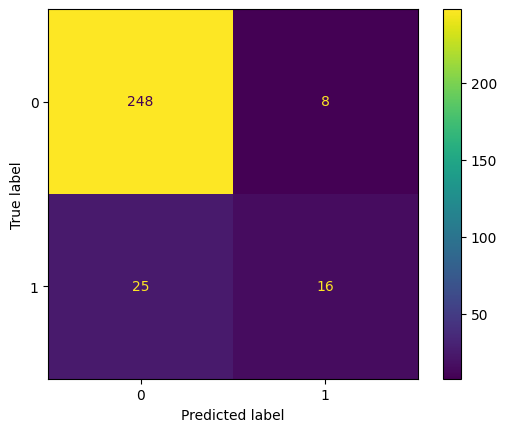

In [24]:
seed = 42
# создаем column transformer: кодируем категориалььные признаки с помощью OneHot, численные - StandardScaler, остальные признаки не трогаем (их нет на самом деле)
column_transformer = ColumnTransformer(
    transformers=[
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
        ("scaling", StandardScaler(), numeric_features),
    ],
    remainder="passthrough",
)

# создаем пайплайн логистической регрессии. тк классы не сбалансированы, используем class_weight = 'balanced'
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            LogisticRegression(random_state=seed, class_weight="balanced"),
        ),
    ]
)

# создаем пайплайн random forest. перебором нашла веса классов с наилучшим качеством
rf_pipeline = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        (
            "BalanceRF",
            RandomForestClassifier(
                class_weight={0: 0.423, 1: 0.589},
                random_state=seed,
                n_estimators=500,
            ),
        ),
    ]
)

# создаем пайплайн SVC. тк потом используем soft voting, обязательно probability=True
svm_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            SVC(
                random_state=seed,
                probability=True,
                class_weight="balanced",
            ),
        ),
    ]
)

# соберем все вместе
ensemble_model = VotingClassifier(
    estimators=[
        ("rf", rf_pipeline),
        ("svm", svm_pipeline),
        ("lr", lr_pipeline),
    ],
    voting="soft",
)

model = ensemble_model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(classification_report(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds))

disp.plot()
plt.show()

Best hyperparameters on the dev set:
{'lr__classifier__C': 1, 'svm__classifier__kernel': 'linear'}
Best score: 0.2199272204351307
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       256
           1       0.67      0.39      0.49        41

    accuracy                           0.89       297
   macro avg       0.79      0.68      0.71       297
weighted avg       0.88      0.89      0.88       297

0.8888888888888888



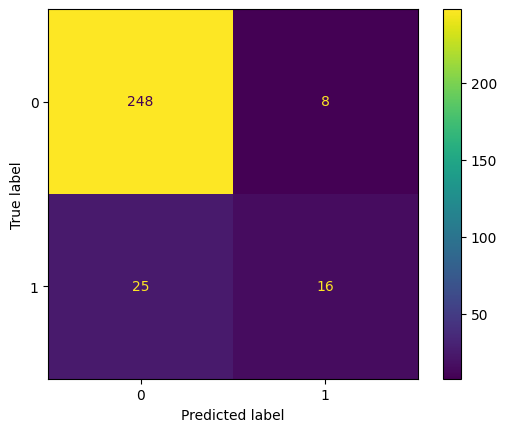

In [17]:
# перебор гиперпараметров
param_grid = {
    "svm__classifier__kernel": ["linear", "poly"],
    "lr__classifier__C": [0.01, 0.1, 1],
}

clf = GridSearchCV(
    ensemble_model,
    param_grid,
    scoring=["f1", "accuracy"],
    cv=3,
    n_jobs=-1,
    refit="f1",
)

clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.best_estimator_.predict(X_test)

print(f"Best hyperparameters on the dev set:\n{clf.best_params_}")
print(f"Best score: {clf.best_score_}")
print(classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))
print()
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))

disp.plot()
plt.show()

# Задача 6. Линрег

Допустим, у вас есть два множества **A** и **B** точек на плоскости. Линейная регрессия на плоскости -- это 
просто прямая, ее можно представить как функцию $ y = ax + b$.

Линейная регрессия, обученная на множестве **А**, имеет коэффициент **$a > 0$**. То же самое верно и для линейной регрессии, обученной на множестве **B**. Правда ли, что если обучить линейную регрессию на множестве $A \cup B$, то у полученной прямой коэффициент **a** будет больше 0?

Если да -  докажите, если нет - постройте контрпример.

Покажем, что утверждение неверно. 

Коэффициент наклона для множества A: 1.9999999999999996
Коэффициент наклона для множества B: 20.999999999999993
Коэффициент наклона для объединенного множества A и B: -0.5819672131147541


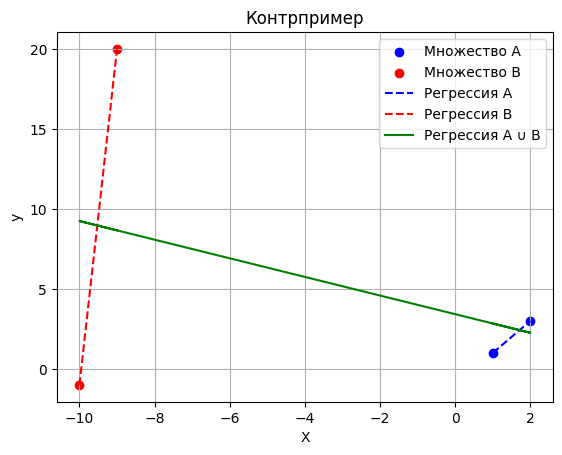

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# изначальные данные
A = np.array([[1, 1], [2, 3]])
B = np.array([[-10, -1], [-9, 20]])
A_union_B = np.vstack((A, B))

# Разделим координаты X и y для множеств A, B и A_union_B
X_A = A[:, 0].reshape(-1, 1)
y_A = A[:, 1]

X_B = B[:, 0].reshape(-1, 1)
y_B = B[:, 1]

X_A_union_B = A_union_B[:, 0].reshape(-1, 1)
y_A_union_B = A_union_B[:, 1]

# обучим модели линейной регрессии для каждого множества
reg_A = LinearRegression().fit(A[:, 0].reshape(-1, 1), A[:, 1])
reg_B = LinearRegression().fit(B[:, 0].reshape(-1, 1), B[:, 1])
reg_A_union_B = LinearRegression().fit(A_union_B[:, 0].reshape(-1, 1), A_union_B[:, 1])

# Коэффициенты наклона для каждого множества
a_A = reg_A.coef_[0]
a_B = reg_B.coef_[0]
a_A_union_B = reg_A_union_B.coef_[0]

print(f"Коэффициент наклона для множества A: {a_A}")
print(f"Коэффициент наклона для множества B: {a_B}")
print(f"Коэффициент наклона для объединенного множества A и B: {a_A_union_B}")

# Визуализируем результаты
plt.scatter(X_A, y_A, color="blue", label="Множество A")
plt.scatter(X_B, y_B, color="red", label="Множество B")
plt.plot(X_A, reg_A.predict(X_A), color="blue", linestyle="--", label="Регрессия A")
plt.plot(X_B, reg_B.predict(X_B), color="red", linestyle="--", label="Регрессия B")
plt.plot(
    X_A_union_B,
    reg_A_union_B.predict(X_A_union_B),
    color="green",
    label="Регрессия A ∪ B",
)

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Контрпример")
plt.grid()
plt.show()